**Data Proprocessing**


In [420]:
%pip install chembl_webresource_client > nul 2>&1
%pip install pandas > nul 2>&1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [421]:
import pandas as pd
from chembl_webresource_client.new_client import new_client

In [500]:
target = new_client.target
target_query = target.search("coronavirus")
targets = pd.DataFrame(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],SARS coronavirus,SARS coronavirus,14.0,False,CHEMBL612575,[],ORGANISM,227859
2,[],Feline coronavirus,Feline coronavirus,14.0,False,CHEMBL612744,[],ORGANISM,12663
3,[],Murine coronavirus,Murine coronavirus,14.0,False,CHEMBL5209664,[],ORGANISM,694005
4,[],Human coronavirus 229E,Human coronavirus 229E,12.0,False,CHEMBL613837,[],ORGANISM,11137
5,[],Human coronavirus OC43,Human coronavirus OC43,12.0,False,CHEMBL5209665,[],ORGANISM,31631
6,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,10.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
7,[],Middle East respiratory syndrome-related coron...,Middle East respiratory syndrome-related coron...,9.0,False,CHEMBL4296578,[],ORGANISM,1335626
8,"[{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...",SARS coronavirus,Replicase polyprotein 1ab,4.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859
9,[],Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,4.0,False,CHEMBL4523582,"[{'accession': 'P0DTD1', 'component_descriptio...",SINGLE PROTEIN,2697049


In [423]:
selected_target = targets.target_chembl_id[6]
selected_target

'CHEMBL3927'

In [424]:
activity = new_client.activity
perform = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [425]:
df = pd.DataFrame(perform)
df.iloc[:, -20:]
# df

,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,=,1,1,=,None,IC50,nM,None,7200.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,=,1,1,=,None,IC50,nM,None,9400.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,=,1,1,=,None,IC50,nM,None,13500.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5
3,=,1,1,=,None,IC50,nM,None,13110.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.11
4,=,1,1,=,None,IC50,nM,None,2000.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,=,1,1,=,None,IC50,nM,None,10600.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,10.6
129,=,1,1,=,None,IC50,nM,None,10100.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,10.1
130,=,1,1,=,None,IC50,nM,None,11500.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,11.5
131,=,1,1,=,None,IC50,nM,None,10700.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,10.7


In [426]:
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2 = df2.drop_duplicates(["canonical_smiles"])
df2 = df2.reset_index(drop=True)
df2.head(5).iloc[:, -20:]

,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,=,1,1,=,None,IC50,nM,None,7200.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,=,1,1,=,None,IC50,nM,None,9400.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,=,1,1,=,None,IC50,nM,None,13500.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5
3,=,1,1,=,None,IC50,nM,None,13110.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.11
4,=,1,1,=,None,IC50,nM,None,2000.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,2.0


In [427]:
selection = ["molecule_chembl_id", "canonical_smiles", "standard_value"]
df3 = df2[selection]
df3 = df3.rename(columns={"standard_value": "IC50"})
df3

,molecule_chembl_id,canonical_smiles,IC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0
...,...,...,...
81,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,21100.0
82,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,226700.0
83,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,38700.0
84,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,14400.0


In [428]:
def calculate_bioactivity_threshold(standard_values):
    bioactivity_threshold = []
    for value in standard_values:
        if float(value) >= 10000:
            bioactivity_threshold.append("inactive")
        elif float(value) <= 1000:
            bioactivity_threshold.append("active")
        else:
            bioactivity_threshold.append("intermediate")

    return bioactivity_threshold

In [429]:
bioactivity_class = calculate_bioactivity_threshold(df3["IC50"])
bioactivity_class = pd.Series(bioactivity_class, name="class")
# bioactivity_class
df4 = pd.concat([df3, bioactivity_class], axis=1)
df4

,molecule_chembl_id,canonical_smiles,IC50,class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate
...,...,...,...,...
81,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,21100.0,inactive
82,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,226700.0,inactive
83,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,38700.0,inactive
84,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,14400.0,inactive


**Data Analysis**


In [430]:
%pip install rdkit > nul 2>&1
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

Note: you may need to restart the kernel to use updated packages.


In [431]:
def lipinski_descriptors(canonical_smile):
    molecule = Chem.MolFromSmiles(canonical_smile)
    if molecule is None:
        return None

    mol_wt = Descriptors.MolWt(molecule)
    logp = Descriptors.MolLogP(molecule)
    h_donors = Descriptors.NumHDonors(molecule)
    h_acceptors = Descriptors.NumHAcceptors(molecule)

    return {
        "MolWt": mol_wt,
        "MolLogP": logp,
        "NumHDonors": h_donors,
        "NumHAcceptors": h_acceptors,
    }

In [432]:
df_lipinski = df4["canonical_smiles"].apply(lipinski_descriptors)
df_lipinski = pd.DataFrame(df_lipinski.tolist())
df_lipinski

,MolWt,MolLogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0,5
1,415.589,3.81320,0,2
2,421.190,2.66050,0,4
3,293.347,3.63080,0,3
4,338.344,3.53900,0,5
...,...,...,...,...
81,338.359,3.40102,0,5
82,296.366,3.44330,0,3
83,276.291,4.09564,0,3
84,278.307,3.29102,0,3


In [433]:
df4

,molecule_chembl_id,canonical_smiles,IC50,class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate
...,...,...,...,...
81,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,21100.0,inactive
82,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,226700.0,inactive
83,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,38700.0,inactive
84,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,14400.0,inactive


In [434]:
df_combined = pd.concat([df4, df_lipinski], axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,IC50,class,MolWt,MolLogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0,5
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0,2
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0,4
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive,293.347,3.63080,0,3
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate,338.344,3.53900,0,5
...,...,...,...,...,...,...,...,...
81,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,21100.0,inactive,338.359,3.40102,0,5
82,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,226700.0,inactive,296.366,3.44330,0,3
83,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,38700.0,inactive,276.291,4.09564,0,3
84,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,14400.0,inactive,278.307,3.29102,0,3


In [435]:
df_combined["IC50"] = pd.to_numeric(df_combined["IC50"])
# df_combined.IC50.describe()

In [436]:
def pIC50(input):
    pIC50 = []

    for i in input["IC50"]:
        molar = i * (10**-9)  # Converts nM to M
        pIC50.append(-np.log10(molar))

    input["pIC50"] = pIC50
    values = input.drop("IC50", axis=1)

    return values

In [437]:
df_final = pIC50(df_combined)
df_final

,molecule_chembl_id,canonical_smiles,class,MolWt,MolLogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0,5,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0,2,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0,4,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0,3,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0,5,5.698970
...,...,...,...,...,...,...,...,...
81,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0,5,4.675718
82,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0,3,3.644548
83,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0,3,4.412289
84,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0,3,4.841638


In [438]:
# df_final.pIC50.describe()

In [439]:
%pip install matplotlib > nul 2>&1
%pip install seaborn > nul 2>&1
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [440]:
# Removing "intermediate" class
filtered_df = df_final[df_final["class"] != "intermediate"]

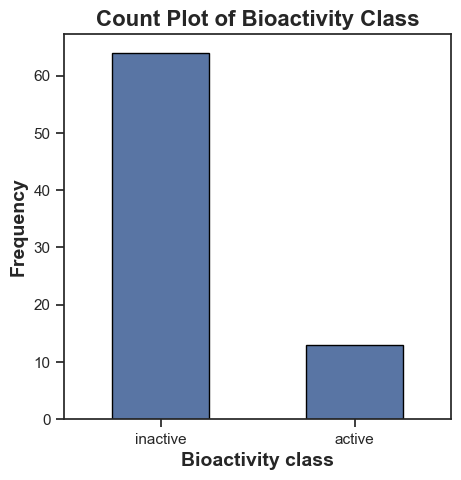

In [441]:
plt.figure(figsize=(5.0, 5.0))
sns.countplot(x="class", data=filtered_df, edgecolor="black", width=0.5)

plt.xlabel("Bioactivity class", fontsize=14, fontweight="bold")
plt.ylabel("Frequency", fontsize=14, fontweight="bold")
plt.title("Count Plot of Bioactivity Class", fontsize=16, fontweight="bold")

plt.show()

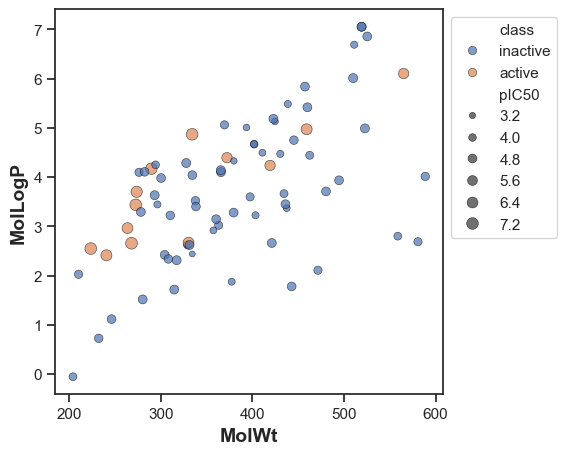

In [442]:
plt.figure(figsize=(5.0, 5.0))
sns.scatterplot(x="MolWt", y="MolLogP", data=filtered_df, hue="class", size="pIC50", edgecolor="black", alpha=0.7)

plt.xlabel("MolWt", fontsize=14, fontweight="bold")
plt.ylabel("MolLogP", fontsize=14, fontweight="bold")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc="upper left")

In [443]:
%pip install scipy > nul 2>&1

Note: you may need to restart the kernel to use updated packages.


In [444]:
def mannwhitneytest(descriptor):
    from scipy.stats import mannwhitneyu

    active = filtered_df[filtered_df["class"] == "active"]
    inactive = filtered_df[filtered_df["class"] == "inactive"]

    active = active[descriptor]
    inactive = inactive[descriptor]

    stat, p = mannwhitneyu(active, inactive)

    alpha = 0.05
    interpretation = (
        "H₀ Failed to Reject (Same Distribution)"
        if p > alpha
        else "H₀ Rejected (Different Distribution)"
    )

    results = pd.DataFrame(
        {
            "Descriptor": descriptor,
            "Statistics": stat,
            "p": p,
            "alpha": alpha,
            "Interpretation": interpretation,
        },
        index=[0],
    )

    return results

d:\Documents\University\3rd SEM\Project Work\.venv\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


Text(0, 0.5, 'MolWt')

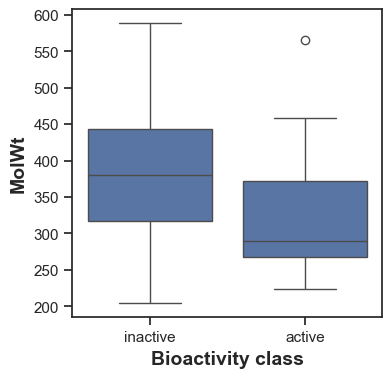

In [445]:
# Moleculer Weight
plt.figure(figsize=(4, 4))

sns.boxplot(x="class", y="MolWt", data=filtered_df)

plt.xlabel("Bioactivity class", fontsize=14, fontweight="bold")
plt.ylabel("MolWt", fontsize=14, fontweight="bold")

In [446]:
mannwhitneytest("MolWt")

,Descriptor,Statistics,p,alpha,Interpretation
0,MolWt,249.0,0.023567,0.05,H₀ Rejected (Different Distribution)


d:\Documents\University\3rd SEM\Project Work\.venv\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


Text(0, 0.5, 'MolLogP')

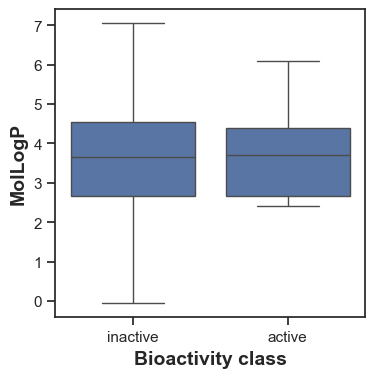

In [447]:
# Moleculer LogP
plt.figure(figsize=(4, 4))

sns.boxplot(x="class", y="MolLogP", data=filtered_df)

plt.xlabel("Bioactivity class", fontsize=14, fontweight="bold")
plt.ylabel("MolLogP", fontsize=14, fontweight="bold")

In [448]:
mannwhitneytest("MolLogP")

,Descriptor,Statistics,p,alpha,Interpretation
0,MolLogP,425.0,0.90798,0.05,H₀ Failed to Reject (Same Distribution)


d:\Documents\University\3rd SEM\Project Work\.venv\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


Text(0, 0.5, 'NumHDonors')

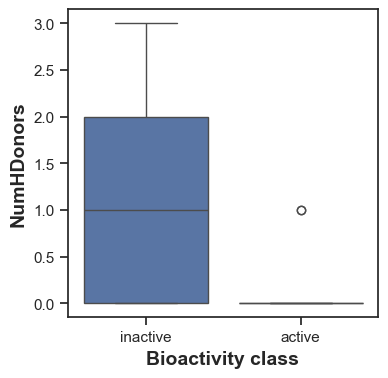

In [449]:
# Number of H Donors
plt.figure(figsize=(4, 4))

sns.boxplot(x="class", y="NumHDonors", data=filtered_df)

plt.xlabel("Bioactivity class", fontsize=14, fontweight="bold")
plt.ylabel("NumHDonors", fontsize=14, fontweight="bold")

In [450]:
mannwhitneytest("NumHDonors")

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,178.5,0.00062,0.05,H₀ Rejected (Different Distribution)


d:\Documents\University\3rd SEM\Project Work\.venv\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


Text(0, 0.5, 'NumHAcceptors')

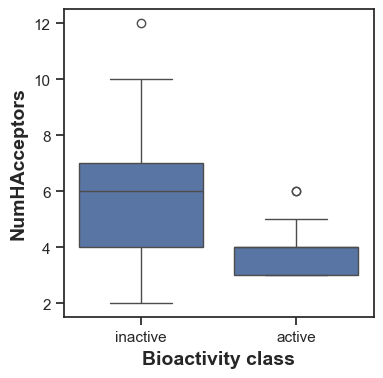

In [451]:
# Number of H Acceptors
plt.figure(figsize=(4, 4))

sns.boxplot(x="class", y="NumHAcceptors", data=filtered_df)

plt.xlabel("Bioactivity class", fontsize=14, fontweight="bold")
plt.ylabel("NumHAcceptors", fontsize=14, fontweight="bold")

In [452]:
mannwhitneytest("NumHAcceptors")

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,248.0,0.020964,0.05,H₀ Rejected (Different Distribution)


d:\Documents\University\3rd SEM\Project Work\.venv\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


Text(0, 0.5, 'pIC50')

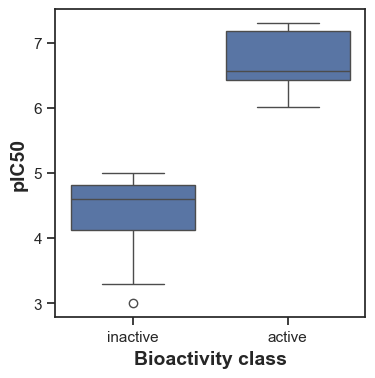

In [453]:
# pIC50
plt.figure(figsize=(4, 4))

sns.boxplot(x="class", y="pIC50", data=filtered_df)

plt.xlabel("Bioactivity class", fontsize=14, fontweight="bold")
plt.ylabel("pIC50", fontsize=14, fontweight="bold")

In [454]:
mannwhitneytest("pIC50")

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,832.0,1.588094e-08,0.05,H₀ Rejected (Different Distribution)


In [455]:
df3_selection = df_final[["canonical_smiles","molecule_chembl_id"]]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [456]:
!java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv

Processing CHEMBL187579 in molecule.smi (1/86). 
Processing CHEMBL187717 in molecule.smi (5/86). 
Processing CHEMBL426082 in molecule.smi (4/86). 
Processing CHEMBL185698 in molecule.smi (3/86). 
Processing CHEMBL188487 in molecule.smi (2/86). 
Processing CHEMBL365134 in molecule.smi (6/86). 
Processing CHEMBL187598 in molecule.smi (7/86). 
Processing CHEMBL190743 in molecule.smi (8/86). 
Processing CHEMBL365469 in molecule.smi (9/86). 
Processing CHEMBL188983 in molecule.smi (10/86). 
Processing CHEMBL191575 in molecule.smi (11/86). 
Processing CHEMBL370923 in molecule.smi (12/86). 
Processing CHEMBL194398 in molecule.smi (13/86). 
Processing CHEMBL196635 in molecule.smi (14/86). 
Processing CHEMBL209287 in molecule.smi (15/86). 
Processing CHEMBL358279 in molecule.smi (16/86). 
Processing CHEMBL379727 in molecule.smi (18/86). Average speed: 1.40 s/mol.
Processing CHEMBL348660 in molecule.smi (17/86). Average speed: 1.93 s/mol.
Processing CHEMBL210525 in molecule.smi (19/86). Average 

In [457]:
# %pip install padelpy > nul 2>&1

# from padelpy import padeldescriptor

# fingerprint = 'PubchemFingerprinter.xml'

# fingerprint_output_file = ''.join([fingerprint,'.csv']) #Substructure.csv

# padeldescriptor(mol_dir='molecule.smi', 
#                 d_file=fingerprint_output_file, #'Substructure.csv'
#                 #descriptortypes='SubstructureFingerprint.xml', 
#                 descriptortypes= fingerprint,
#                 detectaromaticity=True,
#                 standardizenitro=True,
#                 standardizetautomers=True,
#                 threads=2,
#                 removesalt=True,
#                 log=True,
#                 fingerprints=True)

In [458]:
df3_X = pd.read_csv('descriptors_output.csv')
# df3_X
df3_X = df3_X.drop(columns=['Name'])
df3_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
82,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
83,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [459]:
df3_Y = df_final['pIC50']
df3_Y

0     5.142668
1     5.026872
2     4.869666
3     4.882397
4     5.698970
        ...   
81    4.675718
82    3.644548
83    4.412289
84    4.841638
85    4.675718
Name: pIC50, Length: 86, dtype: float64

In [460]:
%pip install scikit-learn > nul 2>&1

Note: you may need to restart the kernel to use updated packages.


In [461]:
from sklearn.feature_selection import VarianceThreshold

def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selected_data = selection.fit_transform(input_data)
    selected_columns = input_data.columns[selection.get_support(indices=True)]
    return pd.DataFrame(selected_data, columns=selected_columns)

df3_X = remove_low_variance(df3_X, threshold=0.1)
df3_X

,PubchemFP2,PubchemFP12,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP20,PubchemFP23,PubchemFP33,PubchemFP34,PubchemFP37,...,PubchemFP710,PubchemFP712,PubchemFP716,PubchemFP734,PubchemFP758,PubchemFP776,PubchemFP779,PubchemFP797,PubchemFP818,PubchemFP821
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
1,0,0,1,0,0,0,1,0,0,1,...,1,0,0,0,1,0,0,0,0,1
2,0,0,1,1,0,0,0,0,0,0,...,1,0,1,1,1,0,1,1,0,1
3,0,1,1,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
4,0,1,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,1,1,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,0,1,1,0
82,1,1,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,0,1,1,0
83,1,1,0,0,0,1,0,0,0,0,...,1,1,0,1,0,1,0,1,1,0
84,0,1,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,0,1,1,0


In [462]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df3_X, df3_Y, test_size=0.2)

In [463]:
X_train.shape, Y_train.shape

((68, 254), (68,))

In [464]:
X_test.shape, Y_test.shape

((18, 254), (18,))

In [469]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.12564414412416558

In [470]:
Y_pred = model.predict(X_test)
Y_pred

array([3.98922091, 4.45614825, 4.93694304, 4.93918501, 4.8899571 ,
       4.59675127, 4.45614825, 4.04843833, 4.93897456, 3.46913376,
       5.60116153, 4.6864113 , 5.12531643, 4.43498067, 5.18570461,
       4.01601398, 4.40886964, 4.76270521])

In [498]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(Y_test.values, Y_pred)
rsquare = r2_score(Y_test.values, Y_pred)

print("Mean squared error (MSE):", round(mse, 2))
print("Coefficient of Determination (R²):", round(rsquare, 2))

Mean squared error (MSE): 0.82
Coefficient of Determination (R²): 0.13


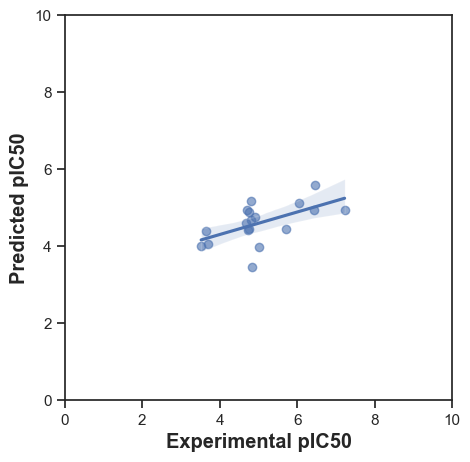

In [495]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))

plot = sns.regplot(x=Y_test, y=Y_pred, scatter_kws={'alpha': 0.6})

plot.set_xlim(0, 10)
plot.set_ylim(0, 10)

plt.xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
plt.ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
plt.show()

In [501]:
import pickle

In [502]:
pickle.dump(model, open("SARS_coronavirus.pkl", "wb"))